In [150]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import learning_curve

from nltk import word_tokenize, download          
from nltk.stem import WordNetLemmatizer 
from sklearn.model_selection import train_test_split

download('punkt')

from database.main import Database
db = Database()

%load_ext autoreload
%autoreload 2

%matplotlib inline

[nltk_data] Downloading package punkt to /home/marco/nltk_data...


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[nltk_data]   Package punkt is already up-to-date!


In [151]:
class LemmaTokenizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]



df = db.read_articles()
df.head()

,category,title,content,topics,published_on
0,lifeandstyle,My pandemic epiphany: I'd be happy to parent f...,"Back in February, a fellow mom of a one-year-o...","[Family, My pandemic epiphany, Children, Paren...",2020-06-12 06:45:54.008
1,sport,AFL still facing 'significant' financial chall...,The AFL season resumption delivered a record-b...,"[AFL, Australian rules football, Australia spo...",2020-06-12 06:45:54.005
2,global-development,Global protests throw spotlight on alleged pol...,"Student Eden Armando Bebari, 19, was allegedly...","[Human rights, Black Lives Matter movement, Ge...",2020-06-12 06:45:54.002
3,sport,Héritier Lumumba rejects Collingwood's offer t...,Héritier Lumumba says he has “no intention” of...,"[AFL, Australian rules football, Australia spo...",2020-06-12 06:45:54.005
4,politics,Brexit: UK expected to backtrack on full EU bo...,The government is expected to backtrack on its...,"[Brexit, European Union, news]",2020-06-12 06:45:54.001


## Base model

In [152]:
data = df[['content', 'category']].copy()

factorized_cats = pd.factorize(df['category'])

data.loc[:,'category'] = factorized_cats[0]
data_cat_map = factorized_cats[1]

data.head()

,content,category
0,"Back in February, a fellow mom of a one-year-o...",0
1,The AFL season resumption delivered a record-b...,1
2,"Student Eden Armando Bebari, 19, was allegedly...",2
3,Héritier Lumumba says he has “no intention” of...,1
4,The government is expected to backtrack on its...,3


MultinomialNB classification report
              precision    recall  f1-score   support

           0       0.84      0.81      0.82       202
           1       0.99      0.94      0.96       200
           2       0.89      0.91      0.90       200
           3       0.84      0.92      0.88       201
           4       0.83      0.98      0.89       205
           5       0.79      0.84      0.82       201
           6       0.99      0.68      0.80       200
           7       0.86      0.90      0.88       200

    accuracy                           0.87      1609
   macro avg       0.88      0.87      0.87      1609
weighted avg       0.88      0.87      0.87      1609



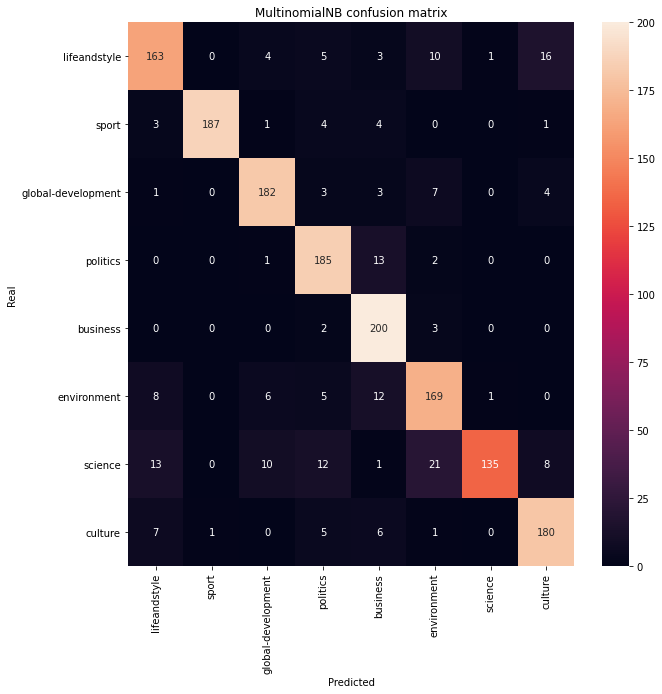

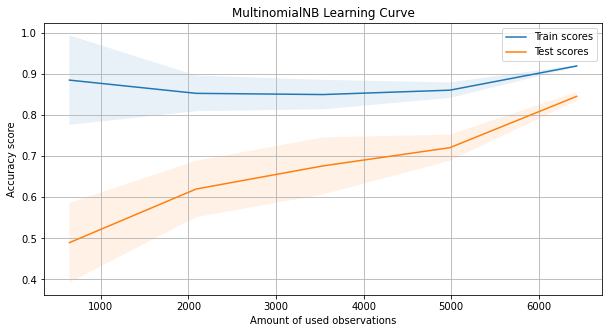

In [176]:
from sklearn.svm import LinearSVC

X, y = data['content'], data['category']


tf = TfidfVectorizer(
    stop_words='english'
)
X = tf.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=123)


def train(estimator, est_name, X_train, y_train):
    estimator.fit(X_train, y_train)
    predictions = estimator.predict(X_test)
    
    print(f"{est_name} classification report")
    print(classification_report(y_test, predictions))
    
    # Confusion matrix
    cm = confusion_matrix(y_test, predictions)

    fig, ax = plt.subplots(figsize=(10, 10))
    sns.heatmap(cm, annot=True, xticklabels=data_cat_map, yticklabels=data_cat_map, fmt='g')
    plt.xlabel("Predicted")
    plt.ylabel("Real")
    plt.title(f"{est_name} confusion matrix")

    plt.show()
    

    # Learning curve
    lc_results = learning_curve(estimator, X, y, cv=5, n_jobs=-1, random_state=123)

    xlabel = lc_results[0]

    mean_train_scores = np.array([ np.mean(scores) for scores in lc_results[1]])
    mean_test_scores = np.array([ np.mean(scores) for scores in lc_results[2]])

    std_train_scores = np.array([ np.std(scores) for scores in lc_results[1]])
    std_test_scores = np.array([ np.std(scores) for scores in lc_results[2]])

    fig, ax = plt.subplots(1, 1, figsize=(10, 5))

    sns.lineplot(x=xlabel, y=mean_train_scores, ax=ax, label="Train scores")
    sns.lineplot(x=xlabel, y=mean_test_scores, ax=ax, label="Test scores")

    ax.grid()
    ax.fill_between(xlabel, mean_train_scores - std_train_scores,
                         mean_train_scores + std_train_scores, alpha=0.1)
    ax.fill_between(xlabel, mean_test_scores - std_test_scores,
                         mean_test_scores + std_test_scores, alpha=0.1)



    plt.title(f"{est_name} Learning Curve")
    plt.xlabel("Amount of used observations")
    plt.ylabel("Accuracy score")

    plt.show()
    


# mb = LinearSVC(C=1.0, dual=True, loss='hinge', penalty='l2', tol=1e-05)

train(MultinomialNB(), "MultinomialNB", X_train, y_train)


## Hyperparameter tuning using TPOT - Genetic algorithm

In [156]:
tpot = TPOTClassifier(generations=3, population_size=5,
    verbosity=2, offspring_size=10,
    scoring='accuracy', cv=5, config_dict='TPOT sparse',
    n_jobs=-1
)

print(tpot.fit(X_train, y_train))
print(tpot.score(X_test, y_test))


Generation 1 - Current best internal CV score: 0.8491929704993468
Generation 2 - Current best internal CV score: 0.9014317115405763
Generation 3 - Current best internal CV score: 0.9031420799694516
Best pipeline: LinearSVC(input_matrix, C=0.5, dual=True, loss=squared_hinge, penalty=l2, tol=0.001)
TPOTClassifier(config_dict='TPOT sparse', crossover_rate=0.1, cv=5,
               disable_update_check=False, early_stop=None, generations=3,
               log_file=<ipykernel.iostream.OutStream object at 0x7f1802b18640>,
               max_eval_time_mins=5, max_time_mins=None, memory=None,
               mutation_rate=0.9, n_jobs=-1, offspring_size=10,
               periodic_checkpoint_folder=None, population_size=5,
               random_state=None, scoring='accuracy', subsample=1.0,
               template=None, use_dask=False, verbosity=2, warm_start=False)
0.9105034182722188


Linear SVC classification report
              precision    recall  f1-score   support

           0       0.86      0.84      0.85       202
           1       0.98      0.96      0.97       200
           2       0.94      0.95      0.94       200
           3       0.95      0.93      0.94       201
           4       0.93      0.95      0.94       205
           5       0.84      0.90      0.87       201
           6       0.90      0.86      0.88       200
           7       0.89      0.90      0.89       200

    accuracy                           0.91      1609
   macro avg       0.91      0.91      0.91      1609
weighted avg       0.91      0.91      0.91      1609



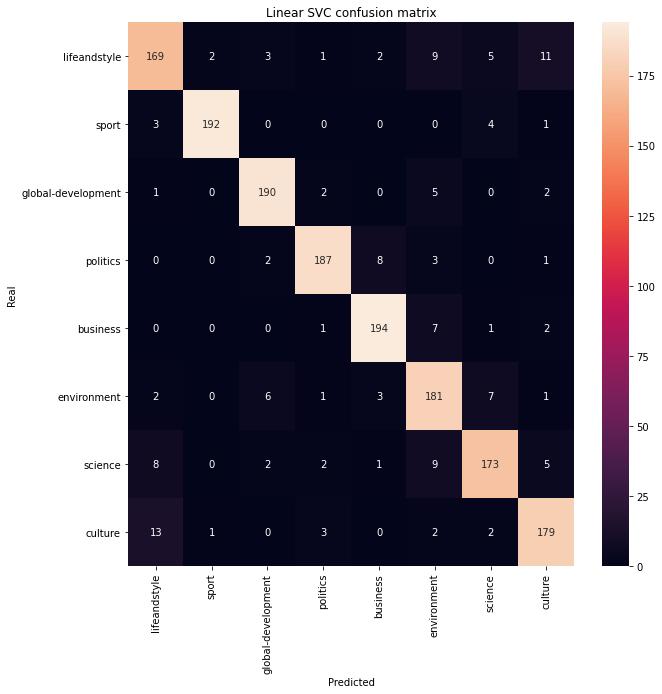

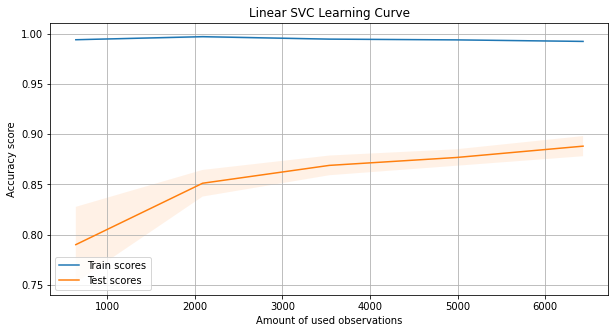

In [177]:
train(LinearSVC(C=0.5, dual=True, loss='squared_hinge', penalty='l2', tol=0.001), "Linear SVC", X_train, y_train)

In [171]:
tpot.evaluated_individuals_

{'RandomForestClassifier(input_matrix, RandomForestClassifier__bootstrap=False, RandomForestClassifier__criterion=gini, RandomForestClassifier__max_features=0.8500000000000001, RandomForestClassifier__min_samples_leaf=12, RandomForestClassifier__min_samples_split=19, RandomForestClassifier__n_estimators=100)': {'generation': 0,
  'mutation_count': 0,
  'crossover_count': 0,
  'predecessor': ('ROOT',),
  'operator_count': 1,
  'internal_cv_score': -inf},
 'RandomForestClassifier(CombineDFs(input_matrix, input_matrix), RandomForestClassifier__bootstrap=True, RandomForestClassifier__criterion=entropy, RandomForestClassifier__max_features=0.9500000000000001, RandomForestClassifier__min_samples_leaf=1, RandomForestClassifier__min_samples_split=2, RandomForestClassifier__n_estimators=100)': {'generation': 0,
  'mutation_count': 0,
  'crossover_count': 0,
  'predecessor': ('ROOT',),
  'operator_count': 1,
  'internal_cv_score': -inf},
 'RandomForestClassifier(input_matrix, RandomForestClassif

In [164]:
to_predict = """
Up to half of all alcoholic drinks consumed in countries across Africa and Latin America are illicit – more than double previous estimates – according to new analysis.

Methanol, mortuary formaldehyde and battery acid were among a cocktail of toxic ingredients found in unregulated drinks, according to the International Alliance for Responsible Drinking (Iard).

In Kenya, one of the most common varieties of home-produced alcohol is called “chang’aa”, or “kill me quick” . The spirit is widely available in poor townships and is often made with contaminated water and potentially lethal methanol. One variant, “jet-five”, is spiked with jet fuel, while another contains embalming fluid.

The figures for consumption of illegal alcohol published by Iard, a non-profit organisation backed by the alcohol industry, exceeded 2014 estimates by the World Health Organization (WHO), which said that illegal and informally produced alcohol accounted for consumed globally.

The Iard report used data from  to look at consumption of illicit alcohol in 26 countries, the majority in Latin America and Africa. It found that in low and middle-income countries, bootleg alcohol accounted for a “sizeable proportion” of total sales.

The report, Alcohol in the Shadow Economy, said illicit alcohol contributes to widening health inequalities.

The production of illegal alcohol, which is cheaper and often more readily available than regulated alcohol, is largely driven by poverty, the report found, although culture was an important factor. Across Africa, many producers of homebrew are women who are the sole earners for their families.

In five of the seven African countries examined – Uganda, Tanzania, Cameroon, Malawi and Mozambique – at least 61% of the alcohol consumed is illicit. Unrecorded alcohol is also widespread across Asia and in parts of Europe, the report said, but comparable data was not available. In Russia, bootleg accounts for 38% of all alcohol consumed.

In April police in Indonesia seized alcohol containing mosquito repellent and cough medicine, after 141 people died from organ failure after drinking moonshine liquor, or oplosan.

It was the worst case of alcohol poisoning in the country, where 24 people died in 2016, and 12 people died in 2014.

Other deaths have occurred over the past decade in Libya, Russia and the Czech Republic, the report said.

The combined revenue loss from illicit alcohol in 18 countries mentioned in the report was found to be $1.8bn (£1.5bn). The loss to Colombia in 2015 was $406m ; in Mozambique, the loss in 2014 was $285m.

Henry Ashworth, Iard CEO and president, said: “What this report tries to do is to show the scale of the challenge and the cost to health, society and to government.”

He cited South Africa, where communities had flagged concern over disorder, noise and crime associated with unregulated drinking houses or shebeens. A code of practice introduced by individual owners had helped increase the quality of alcohol produced and allowed the operators to maintain order and prevent harm, while remaining outside government control. He cited the UK’s thriving microbrewery industry as an example of how countries could produce viable alternatives.

Experts in public health research on alcohol said the report exaggerates the toxic effects of illicit alcohol. Dr Dirk Lachenmeier, of the Chemical and Veterinary Investigation Agency in Karlsruhe, Germany, said: “Much of our research shows that the composition of recorded and unrecorded alcohol is very similar. Considering around a third of alcohol consumed is unrecorded, there are very few cases of poisoning.”

He said: “Our intention should be to lower total consumption of alcohol, both commercial and uncommercial. Of course, this is not something the alcohol industry is going to support.”

"""


p = tf.transform([to_predict])
p

<1x93372 sparse matrix of type '<class 'numpy.float64'>'
	with 232 stored elements in Compressed Sparse Row format>

In [165]:
mb.predict(p)

array([2])

In [167]:
data_cat_map[2]

'global-development'